#Generalizing Deepfake Detection: Cross-Domain Classification of AI-Generated Images

Group #68: Even Li, Jessica Wang, Joanna Wang

# Set up

In our notebook, we primarily depend on PyTorch and Torchvision for building and training models like ResNet and ConvNeXt, as well as for handling image preprocessing. We use Pandas and NumPy for loading and manipulating metadata and numerical arrays. To evaluate model performance, we rely on scikit-learn for metrics like accuracy, precision, and confusion matrices. We also use tqdm to monitor training progress with progress bars, and PIL to load image files. These libraries together support our full training and evaluation pipeline.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.cpu_count())

2


In [ ]:
import kagglehub

path = kagglehub.dataset_download("awsaf49/artifact-dataset")

print("Path to dataset files:", path)

100%|██████████| 29.4G/29.4G [22:45<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1


In [ ]:
!ls -l /root/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1

total 132
drwxr-xr-x  3 root root 4096 May  7 21:00 afhq
drwxr-xr-x  3 root root 4096 May  7 21:00 big_gan
drwxr-xr-x  3 root root 4096 May  7 21:00 celebahq
drwxr-xr-x  3 root root 4096 May  7 21:00 cips
drwxr-xr-x  3 root root 4096 May  7 21:01 coco
drwxr-xr-x  3 root root 4096 May  7 21:01 cycle_gan
drwxr-xr-x  3 root root 4096 May  7 21:01 ddpm
drwxr-xr-x  3 root root 4096 May  7 21:01 denoising_diffusion_gan
drwxr-xr-x  3 root root 4096 May  7 21:01 diffusion_gan
drwxr-xr-x  3 root root 4096 May  7 21:01 face_synthetics
drwxr-xr-x  3 root root 4096 May  7 21:01 ffhq
drwxr-xr-x  3 root root 4096 May  7 21:01 gansformer
drwxr-xr-x  3 root root 4096 May  7 21:01 gau_gan
drwxr-xr-x  4 root root 4096 May  7 21:01 generative_inpainting
drwxr-xr-x  5 root root 4096 May  7 21:02 glide
drwxr-xr-x  3 root root 4096 May  7 21:02 imagenet
drwxr-xr-x  3 root root 4096 May  7 21:02 lama
drwxr-xr-x  3 root root 4096 May  7 21:02 landscape
drwxr-xr-x  4 root root 4096 May  7 21:02 latent_diffusio

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
import random
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### concat all metadata

In [ ]:
dataset_path = path

all_metadata = []

for subdir in os.listdir(dataset_path):
    subdir_path = os.path.join(dataset_path, subdir)
    metadata_file = os.path.join(subdir_path, "metadata.csv")

    if os.path.isfile(metadata_file):
        df = pd.read_csv(metadata_file)
        df["source_folder"] = subdir
        all_metadata.append(df)

metadata = pd.concat(all_metadata, ignore_index=True)

metadata['binary_target'] = metadata['target'].apply(lambda x: 0 if x == 0 else 1)

if "image_path" in metadata.columns and "filepath" not in metadata.columns:
    # build a path that already includes the source-folder prefix
    metadata["filepath"] = (
        metadata["source_folder"].str.rstrip("/") + "/" + metadata["image_path"]
    )

# 1. Problem Statement Refinement and introduction:


## Introduction
The rise of AI-generated media has blurred the line between real and synthetic images, posing new challenges for authentication, misinformation detection, and content moderation. Although many models have been developed to detect deepfakes, most tend to specialize in the types of data they were trained on, making them vulnerable when encountering images generated by unseen models or generators. Our project tackles this generalization challenge: can a machine learning model accurately distinguish real images from synthetic ones across unseen generators and domains?

## Refined Problem Statement
We aim to build a model that can accurately detect whether an image is real or AI-generated, even when evaluated on images from generators not seen during training.
Our baseline model uses a transfer learning approach: features are extracted from a pretrained ResNet50 model, and a lightweight feedforward neural network is trained to perform binary classification (real vs. synthetic) based on these features.

## Significance and Shifts from EDA Insights
Initial assumptions about the dataset's balance and labeling were challenged during exploratory data analysis. We found that the real images and fake images are highly imbalanced, certain generators (e.g., StyleGAN2) dominate the fake data, and non-semantic labels (e.g., “train2017”, “tt-ffhq”) introduce noise. Moreover, t-SNE visualization of feature embeddings showed substantial overlap between real and fake images, suggesting that separating them is not trivial and requires learning subtle artifact-level differences rather than relying on category-level or visual appearance cues.
This deeper understanding shifted our focus toward building a more generalizable classifier and highlighted the need for careful data cleaning and validation design to avoid overfitting to dataset-specific quirks.

# Comprehensive EDA Review:

## Visualization

### Source Distribution

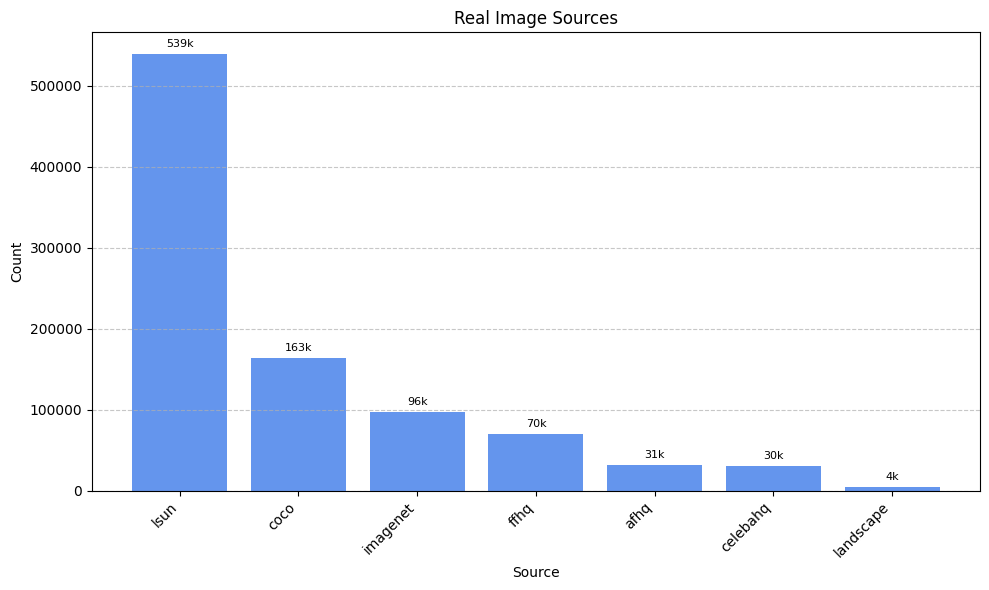

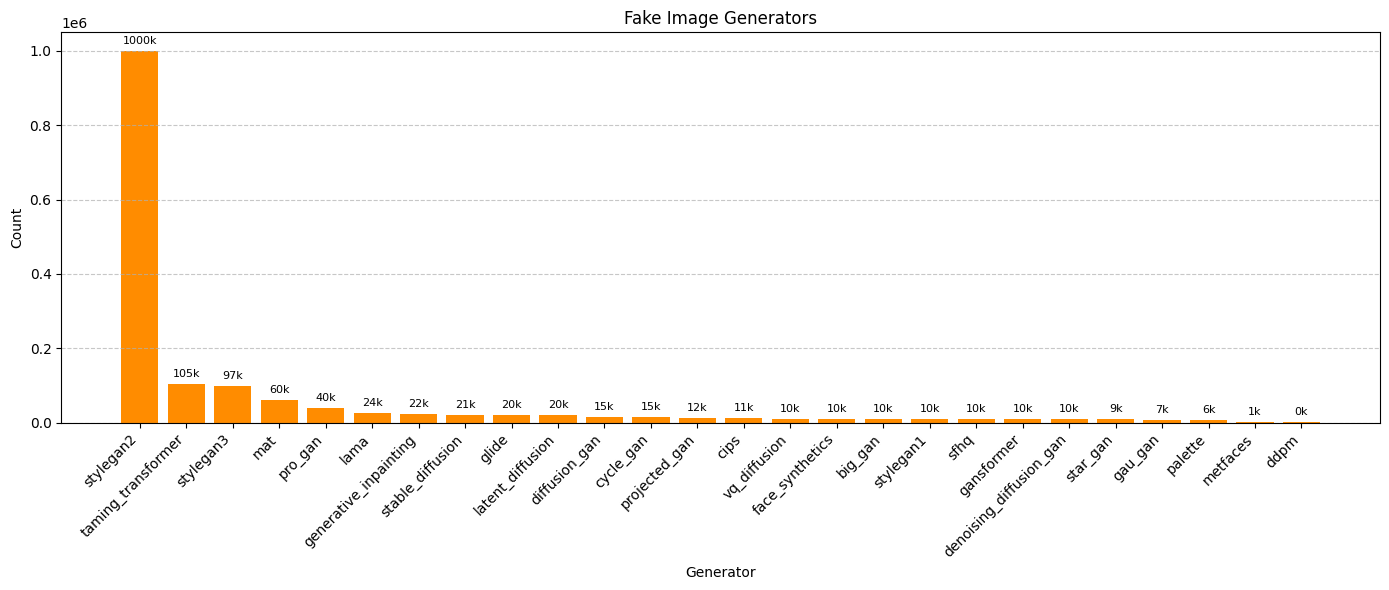

In [ ]:
base_path = '/root/.cache/kagglehub/datasets/awsaf49/artifact-dataset/versions/1'

real_sources = {'afhq', 'celebahq', 'coco', 'ffhq', 'imagenet', 'landscape', 'lsun', 'metafaces'}

real_data = {'Source': [], 'Count': []}
fake_data = {'Source': [], 'Count': []}

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    metadata_path = os.path.join(folder_path, 'metadata.csv')

    if os.path.isfile(metadata_path):
        df = pd.read_csv(metadata_path)
        if folder.lower() in real_sources:
            real_data['Source'].append(folder)
            real_data['Count'].append(len(df))
        else:
            fake_data['Source'].append(folder)
            fake_data['Count'].append(len(df))

df_real = pd.DataFrame(real_data).sort_values('Count', ascending=False)
df_fake = pd.DataFrame(fake_data).sort_values('Count', ascending=False)

plt.figure(figsize=(10, 6))
bars = plt.bar(df_real['Source'], df_real['Count'], color='cornflowerblue')
plt.title('Real Image Sources')
plt.ylabel('Count')
plt.xlabel('Source')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height/1000)}k', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
bars = plt.bar(df_fake['Source'], df_fake['Count'], color='darkorange')
plt.title('Fake Image Generators')
plt.ylabel('Count')
plt.xlabel('Generator')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height/1000)}k', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Figure3.1.1 Real image sources and fake image generators distribution

The unbalanced distributions for real sources and fake generators indicate strong class imbalance among the real sources, which may influence model training bias. Even if the widespread of generator sources ensures diversity, but the skew toward a few major methods may cause overfitting to specific artifacts.



### Category Distribution

In [ ]:
category_counts = metadata['category'].value_counts().reset_index()
category_counts.columns = ['category', 'num_images']

print("Number of images per category:")
print(category_counts)

print("\n Images per category and target (real=0, fake=1):")
print(metadata.groupby(['category', 'target']).size().reset_index(name='count'))

Number of images per category:
     category  num_images
0         cat      340211
1         car      330636
2       horse      329000
3      church      328655
4        ffhq      202000
...       ...         ...
2077      401          20
2078      402          20
2079      403          20
2080      404          20
2081      362          20

[2082 rows x 2 columns]

 Images per category and target (real=0, fake=1):
       category  target  count
0             0       6     20
1             1       6     20
2             2       6     20
3             3       6     20
4             4       6     20
...         ...     ...    ...
2107    tt-ffhq       5  50000
2108  tvmonitor       0   1000
2109  tvmonitor       6   1000
2110    val2017       0   4998
2111       wild       0  10314

[2112 rows x 3 columns]


### Target Value Distribution

<ipython-input-17-cefa0d804746>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata, x='target', palette='Set2')


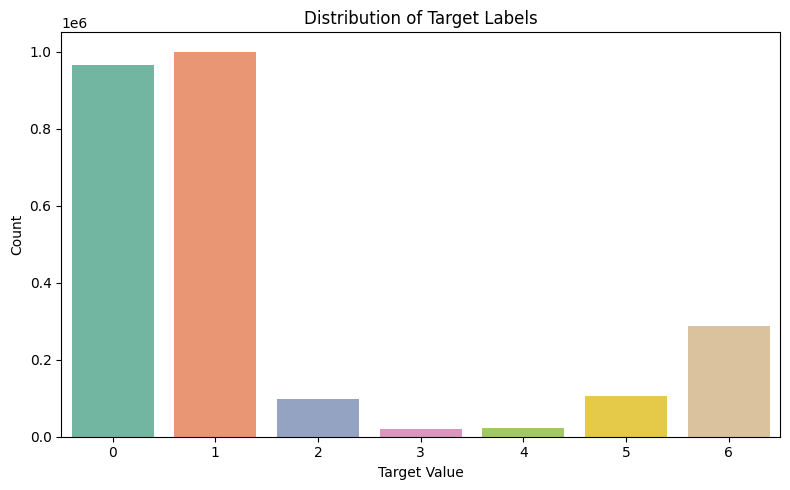

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(data=metadata, x='target', palette='Set2')
plt.title('Distribution of Target Labels')
plt.xlabel('Target Value')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Figure 3.1.3 Target label distibution pre-preprocessing

Images from different generators are labelled with different number instead of real= 0 and fake=1 which is our project's focus.

### Top 10 real/fake image categories

In [ ]:
real_df = metadata[metadata['target'] == 0]
fake_df = metadata[metadata['target'] != 0]

<ipython-input-9-5c32084b748d>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_real, x='count', y='category', palette='Blues_r')


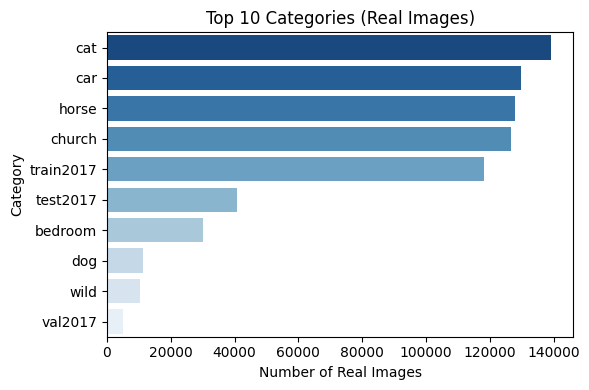

<ipython-input-9-5c32084b748d>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_fake, x='count', y='category', palette='Oranges_r')


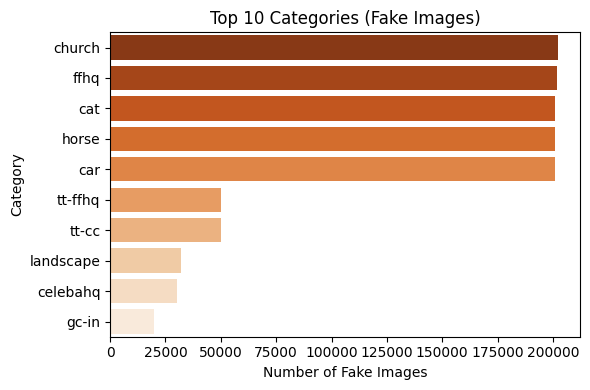

In [ ]:
top10_real = real_df['category'].value_counts().nlargest(10).reset_index()
top10_real.columns = ['category', 'count']

top10_fake = fake_df['category'].value_counts().nlargest(10).reset_index()
top10_fake.columns = ['category', 'count']

plt.figure(figsize=(6, 4))
sns.barplot(data=top10_real, x='count', y='category', palette='Blues_r')
plt.title('Top 10 Categories (Real Images)')
plt.xlabel('Number of Real Images')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=top10_fake, x='count', y='category', palette='Oranges_r')
plt.title('Top 10 Categories (Fake Images)')
plt.xlabel('Number of Fake Images')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


Figure 3.1.4 Top 10 real/fake image category

The original dataset contains non-semantical categories, however, the authors do not mention handling the case when some real images have missing categories, nor balancing train/val splits based on categories. They only randomly sampled real images and generated synthetic images targeting similar categories, but they did not mention balancing the number of images across categories.

### Potential Generator Bias per Category

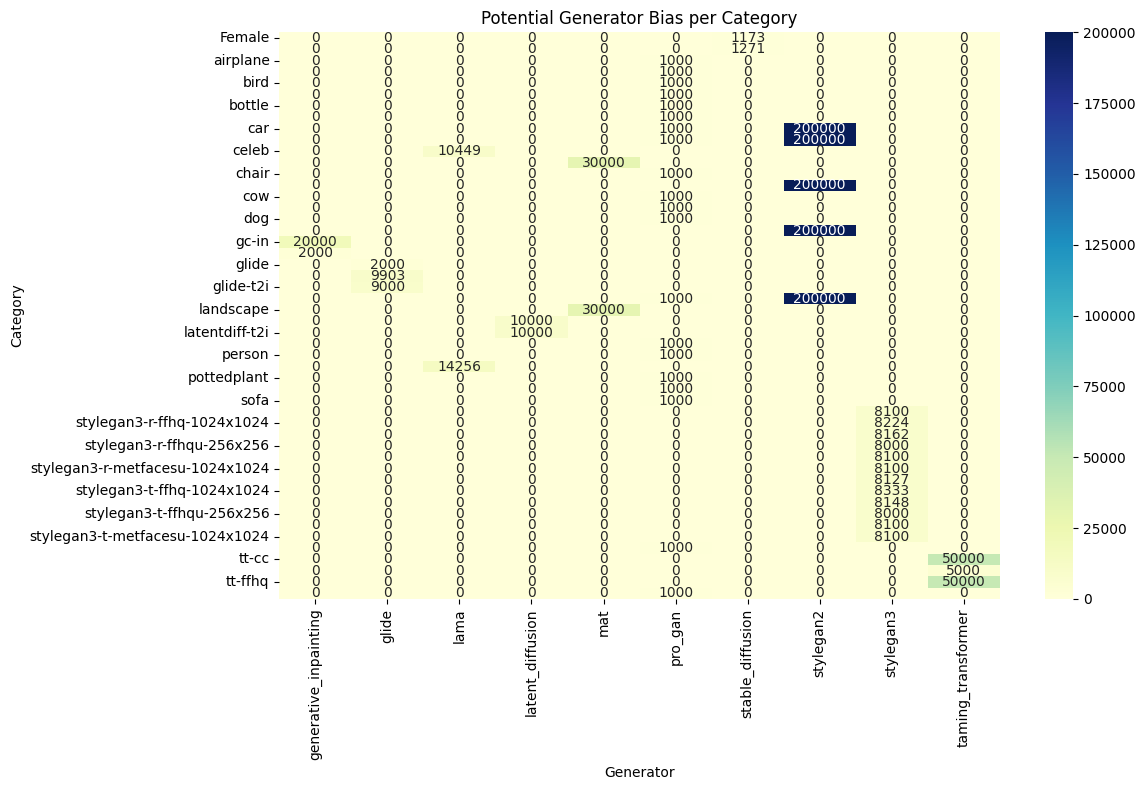

In [ ]:
top_categories = fake_df['category'].value_counts().nlargest(20).index
filtered_df = fake_df[fake_df['category'].isin(top_categories)]
top_generators = fake_df['source_folder'].value_counts().nlargest(10).index
filtered_df = fake_df[fake_df['source_folder'].isin(top_generators)]

bias_matrix = (
    filtered_df
    .groupby(['category', 'source_folder'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 8))
sns.heatmap(bias_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Potential Generator Bias per Category')
plt.xlabel('Generator')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

Figure 3.1.5 Distribution of category per generator

This heatmap reveals generator-specific biases in content generation, e.g., certain categories like “dog”, “person”, or “landscape” are highly overrepresented in a few generators (e.g., stylegan2, taming_transformer). The sparsity and blocky artifacts suggest that some generators are specialized or narrowly trained. This makes us thinking about subsampling.

### MAT Details

In [ ]:
mat_fake_df = metadata[(metadata['target'] != 0) & (metadata['source_folder'] == 'mat')]

print(f"Number of fake images generated by MAT: {len(mat_fake_df)}")

Number of fake images generated by MAT: 60000


Categories of fake images generated by MAT:
    category  count
0   celebahq  30000
1  landscape  30000


<ipython-input-11-4b61b0afc3a7>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mat_category_counts.head(10), x='count', y='category', palette='Purples_r')


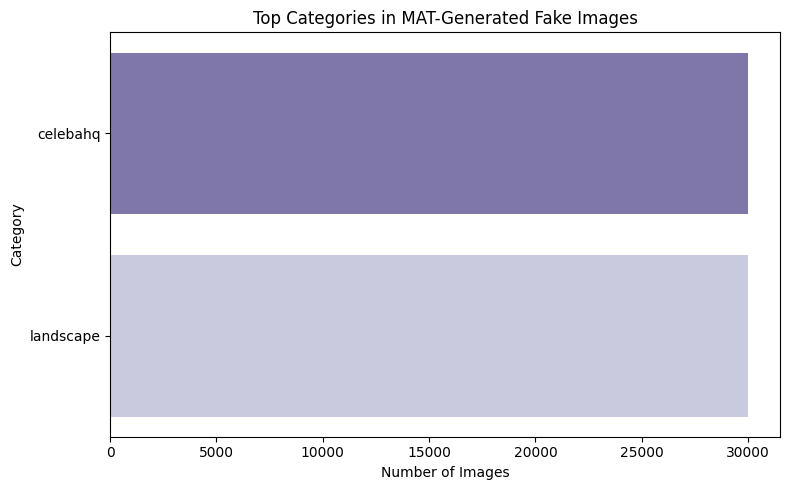

In [ ]:
mat_category_counts = mat_fake_df['category'].value_counts().reset_index()
mat_category_counts.columns = ['category', 'count']

print("Categories of fake images generated by MAT:")
print(mat_category_counts)

plt.figure(figsize=(8, 5))
sns.barplot(data=mat_category_counts.head(10), x='count', y='category', palette='Purples_r')
plt.title('Top Categories in MAT-Generated Fake Images')
plt.xlabel('Number of Images')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

Figure 3.1.6 MAT generator image category distribution

MAT is a less dominant generator in our dataset, contributing 60,000 images—a moderate but meaningful amount.Within the MAT subset, two categories dominate: celebahq and landscape, each with 30,000 images. This means validation performance will primarily reflect the model's ability to detect fakes in facial and landscape content—common in real-world applications. However, this focus may limit generalizability. Future evaluations may stratify results by content type or include a secondary validation set with a different category mix.

### MAT t-SNE distribution

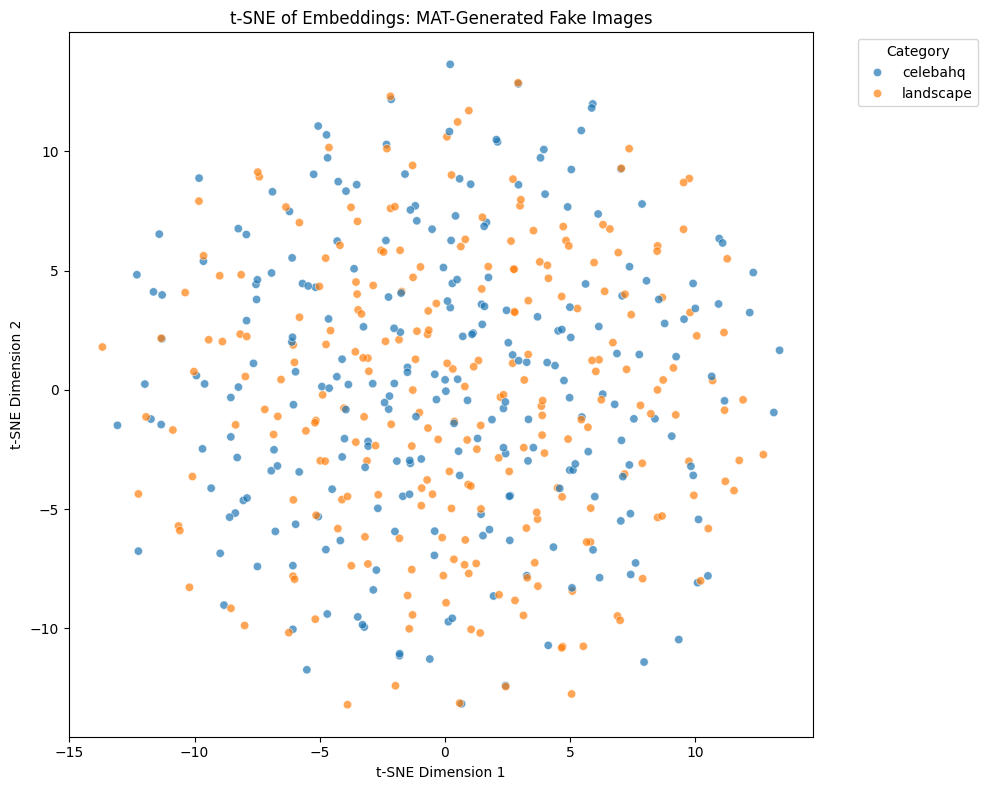

In [ ]:
mat_sample_df = mat_fake_df.sample(n=min(500, len(mat_fake_df)), random_state=42).reset_index(drop=True)

mat_embeddings = np.random.rand(len(mat_sample_df), 512)

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(mat_embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1],
                hue=mat_sample_df['category'], palette='tab10', alpha=0.7)
plt.title('t-SNE of Embeddings: MAT-Generated Fake Images')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Figure 3.1.7 t-SNE of the embedding of the 2 image category appeared in MAT

MAT introduces consistent low-level features, such as texture or compression noise, across categories. These findings support MAT's value as a challenging validation set that tests the model's ability to detect subtle artifacts rather than rely on semantic differences.

## Pre-processing

### Create labels

Even if the original dataset labelled images from different generator with different number, our current model is binary (real vs. fake). So that, we should map all `target != 0` to 1 (fake) and 0 for real for consistency.

In [ ]:
metadata['binary_target'] = metadata['target'].apply(lambda x: 'Real (0)' if x == 0 else 'Fake (!=0)')

In [ ]:
metadata['binary_target'] = metadata['target'].apply(lambda x: 0 if x == 0 else 1)

<ipython-input-20-c16ad4ab071f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata, x='binary_target', palette='Set2')


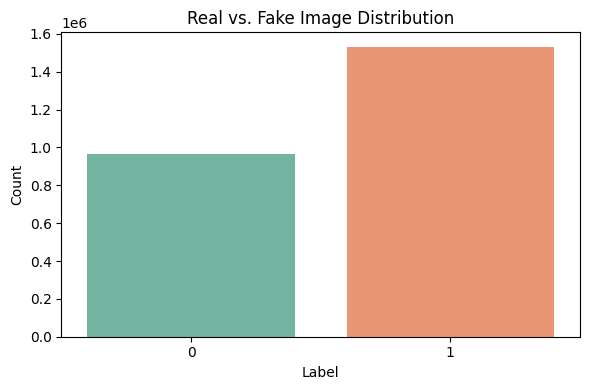

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(data=metadata, x='binary_target', palette='Set2')
plt.title('Real vs. Fake Image Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Figure 3.2.1 Real/fake target label post-preprocessing

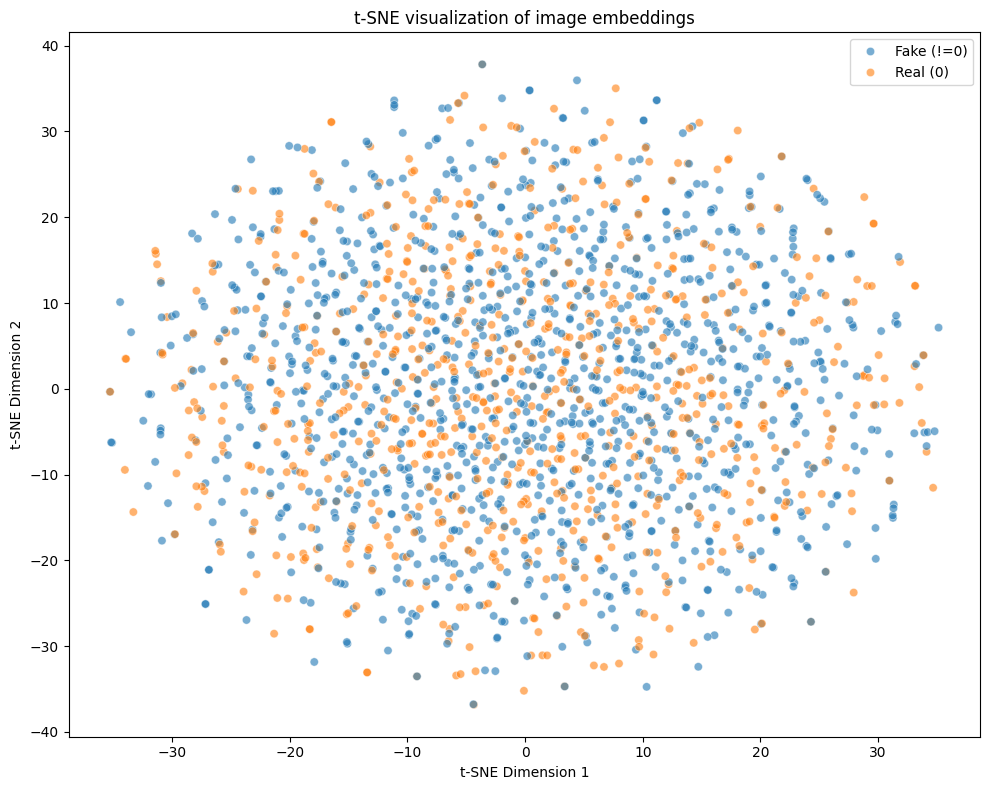

In [ ]:
sample_df = metadata.sample(2000)
embeddings = np.random.rand(2000, 512)
labels = sample_df['binary_target'].values

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

plt.figure(figsize=(10,8))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], hue=labels, alpha=0.6)
plt.title('t-SNE visualization of image embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

This t-SNE plot of 1000 random samples shows significant overlap between real and fake image embeddings, highlighting the challenge of distinguishing them.

Figure 3.2.1.2 t-SNE of the embedding of the real/fake images

### Reduce Sample size

To efficiently train and evaluate our model while controlling for source- and class-imbalance, we now perform a three-way split (train / validation / test) with per-source subsampling and stratified splitting. The steps are:

1. **Reserve fixed-size test sets**
   - Real test: sample exactly 1,000 images from the celebahq dataset. We chose CelebA-HQ as an unseen real source because its high-resolution face crops and unique collection pipeline introduce different resolutions, lighting, and compression artifacts, forcing the model to generalize beyond training distributions.
   - Fake test: sample exactly 1,000 images from the MAT-generated set. We use MAT as our sole fake test generator because our objective is to assess whether the model can generalize to a completely new, unseen generator beyond those included in training.

2. **Define the train + val pool**
   - Exclude both celebahq and MAT images.
   - Remaining real sources are the eight original datasets minus celebahq.
   - Remaining fake sources are all other generators except MAT.

3. **Subsample per source**
   For each of those remaining real and fake sources, sample up to 1,000 images (if a source has fewer than 1,000, take them all). This caps any one generator from dominating.

4. **Merge and shuffle**
   Concatenate the real-and-fake samples into one DataFrame, then shuffle with a fixed random seed for reproducibility.

5. **Stratified train/validation split**
   Use scikit-learn’s `train_test_split(test_size=0.2, stratify=…)` on the pooled data—stratifying on the real-vs-fake label—to preserve the overall class ratio in both train and validation.

6. **Perfectly balance validation**
   We take all real examples in `val_df` and down-sample the fake side to match. Then re-shuffle. Perfect balancing ensures that performance metrics and decision-thresholds aren't biased by class imbalances, giving a clearer picture of model discrimination.

**Outcome**

* **Train**: a balanced mix of up to 1,000 images per non-“celebahq” real source and per non-MAT fake source.
* **Validation**: 20% of that pool (stratified), post-balanced to equal real/fake.
* **Test**: 1,000 held-out celebahq images + 1,000 held-out MAT images.


In [ ]:
TARGET_SAMPLES_PER_SOURCE = 1000
TEST_REAL_SOURCE = 'celebahq'
TEST_FAKE_SOURCE = 'mat'
TEST_SIZE = 0.2
RANDOM_STATE = 42

sf_lower = metadata['source_folder'].str.lower()
excluded_sources = {TEST_REAL_SOURCE, TEST_FAKE_SOURCE}
real_sources = {'afhq', 'coco', 'ffhq', 'imagenet', 'landscape', 'lsun', 'metafaces'}

test_real_df = metadata[sf_lower == TEST_REAL_SOURCE] \
    .sample(n=TARGET_SAMPLES_PER_SOURCE, random_state=RANDOM_STATE)

test_fake_df = metadata[sf_lower == TEST_FAKE_SOURCE] \
    .sample(n=TARGET_SAMPLES_PER_SOURCE, random_state=RANDOM_STATE)

trainval_real_df = metadata[
    sf_lower.isin(real_sources) & ~sf_lower.isin(excluded_sources)
]

trainval_fake_df = metadata[
    ~sf_lower.isin(real_sources) & ~sf_lower.isin(excluded_sources)
]

def sample_per_source(df, target):
    pieces = []
    for src in df['source_folder'].unique():
        sub = df[df['source_folder'] == src]
        pieces.append(sub.sample(n=min(len(sub), target), random_state=RANDOM_STATE))
    return pd.concat(pieces, ignore_index=True)

sv_real = sample_per_source(trainval_real_df, TARGET_SAMPLES_PER_SOURCE)
sv_fake = sample_per_source(trainval_fake_df, TARGET_SAMPLES_PER_SOURCE)

trainval_df = pd.concat([sv_real, sv_fake], ignore_index=True) \
    .sample(frac=1, random_state=RANDOM_STATE)

train_df, val_df = train_test_split(
    trainval_df,
    test_size=TEST_SIZE,
    stratify=trainval_df['source_folder'].str.lower().isin(real_sources),
    random_state=RANDOM_STATE
)

val_real = val_df[val_df['source_folder'].str.lower().isin(real_sources)]
val_fake = val_df[~val_df['source_folder'].str.lower().isin(real_sources)] \
    .sample(n=len(val_real), random_state=RANDOM_STATE)

val_df = pd.concat([val_real, val_fake], ignore_index=True) \
    .sample(frac=1, random_state=RANDOM_STATE) \
    .reset_index(drop=True)

print(f"Test real  set: {len(test_real_df)}")
print(f"Test fake  set: {len(test_fake_df)}")
print(f"Train set:      {len(train_df)}")
print(f"Validation set: {len(val_df)}")
print("  Real in val:", (val_df['source_folder'].str.lower().isin(real_sources)).sum())
print("  Fake in val:", (~val_df['source_folder'].str.lower().isin(real_sources)).sum())

Test real  set: 1000
Test fake  set: 1000
Train set:      24716
Validation set: 2400
  Real in val: 1200
  Fake in val: 1200


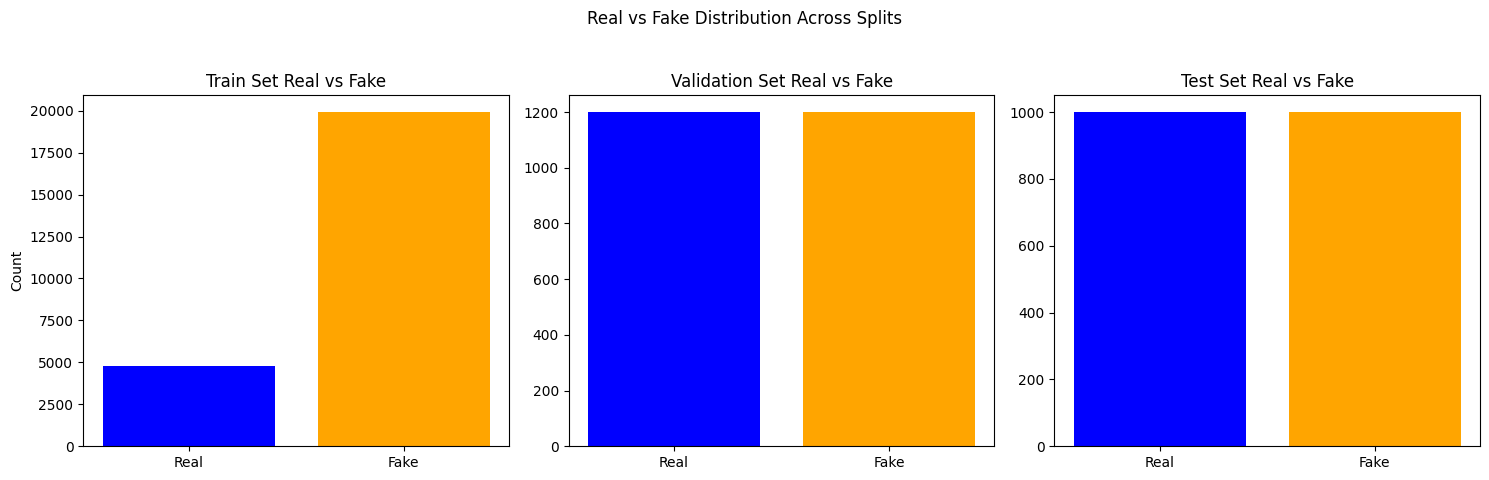

In [ ]:
train_real_count = (train_df['source_folder'].str.lower().isin(real_sources)).sum()
train_fake_count = len(train_df) - train_real_count

val_real_count = (val_df['source_folder'].str.lower().isin(real_sources)).sum()
val_fake_count = len(val_df) - val_real_count

test_real_count = len(test_real_df)
test_fake_count = len(test_fake_df)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(['Real', 'Fake'], [train_real_count, train_fake_count], color=['blue', 'orange'])
axes[0].set_title('Train Set Real vs Fake')
axes[0].set_ylabel('Count')

axes[1].bar(['Real', 'Fake'], [val_real_count, val_fake_count], color=['blue', 'orange'])
axes[1].set_title('Validation Set Real vs Fake')

axes[2].bar(['Real', 'Fake'], [test_real_count, test_fake_count], color=['blue', 'orange'])
axes[2].set_title('Test Set Real vs Fake')

plt.suptitle('Real vs Fake Distribution Across Splits')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Figure 3.2.2.1 Real/fake image distirbution for Train, Validation, Test set

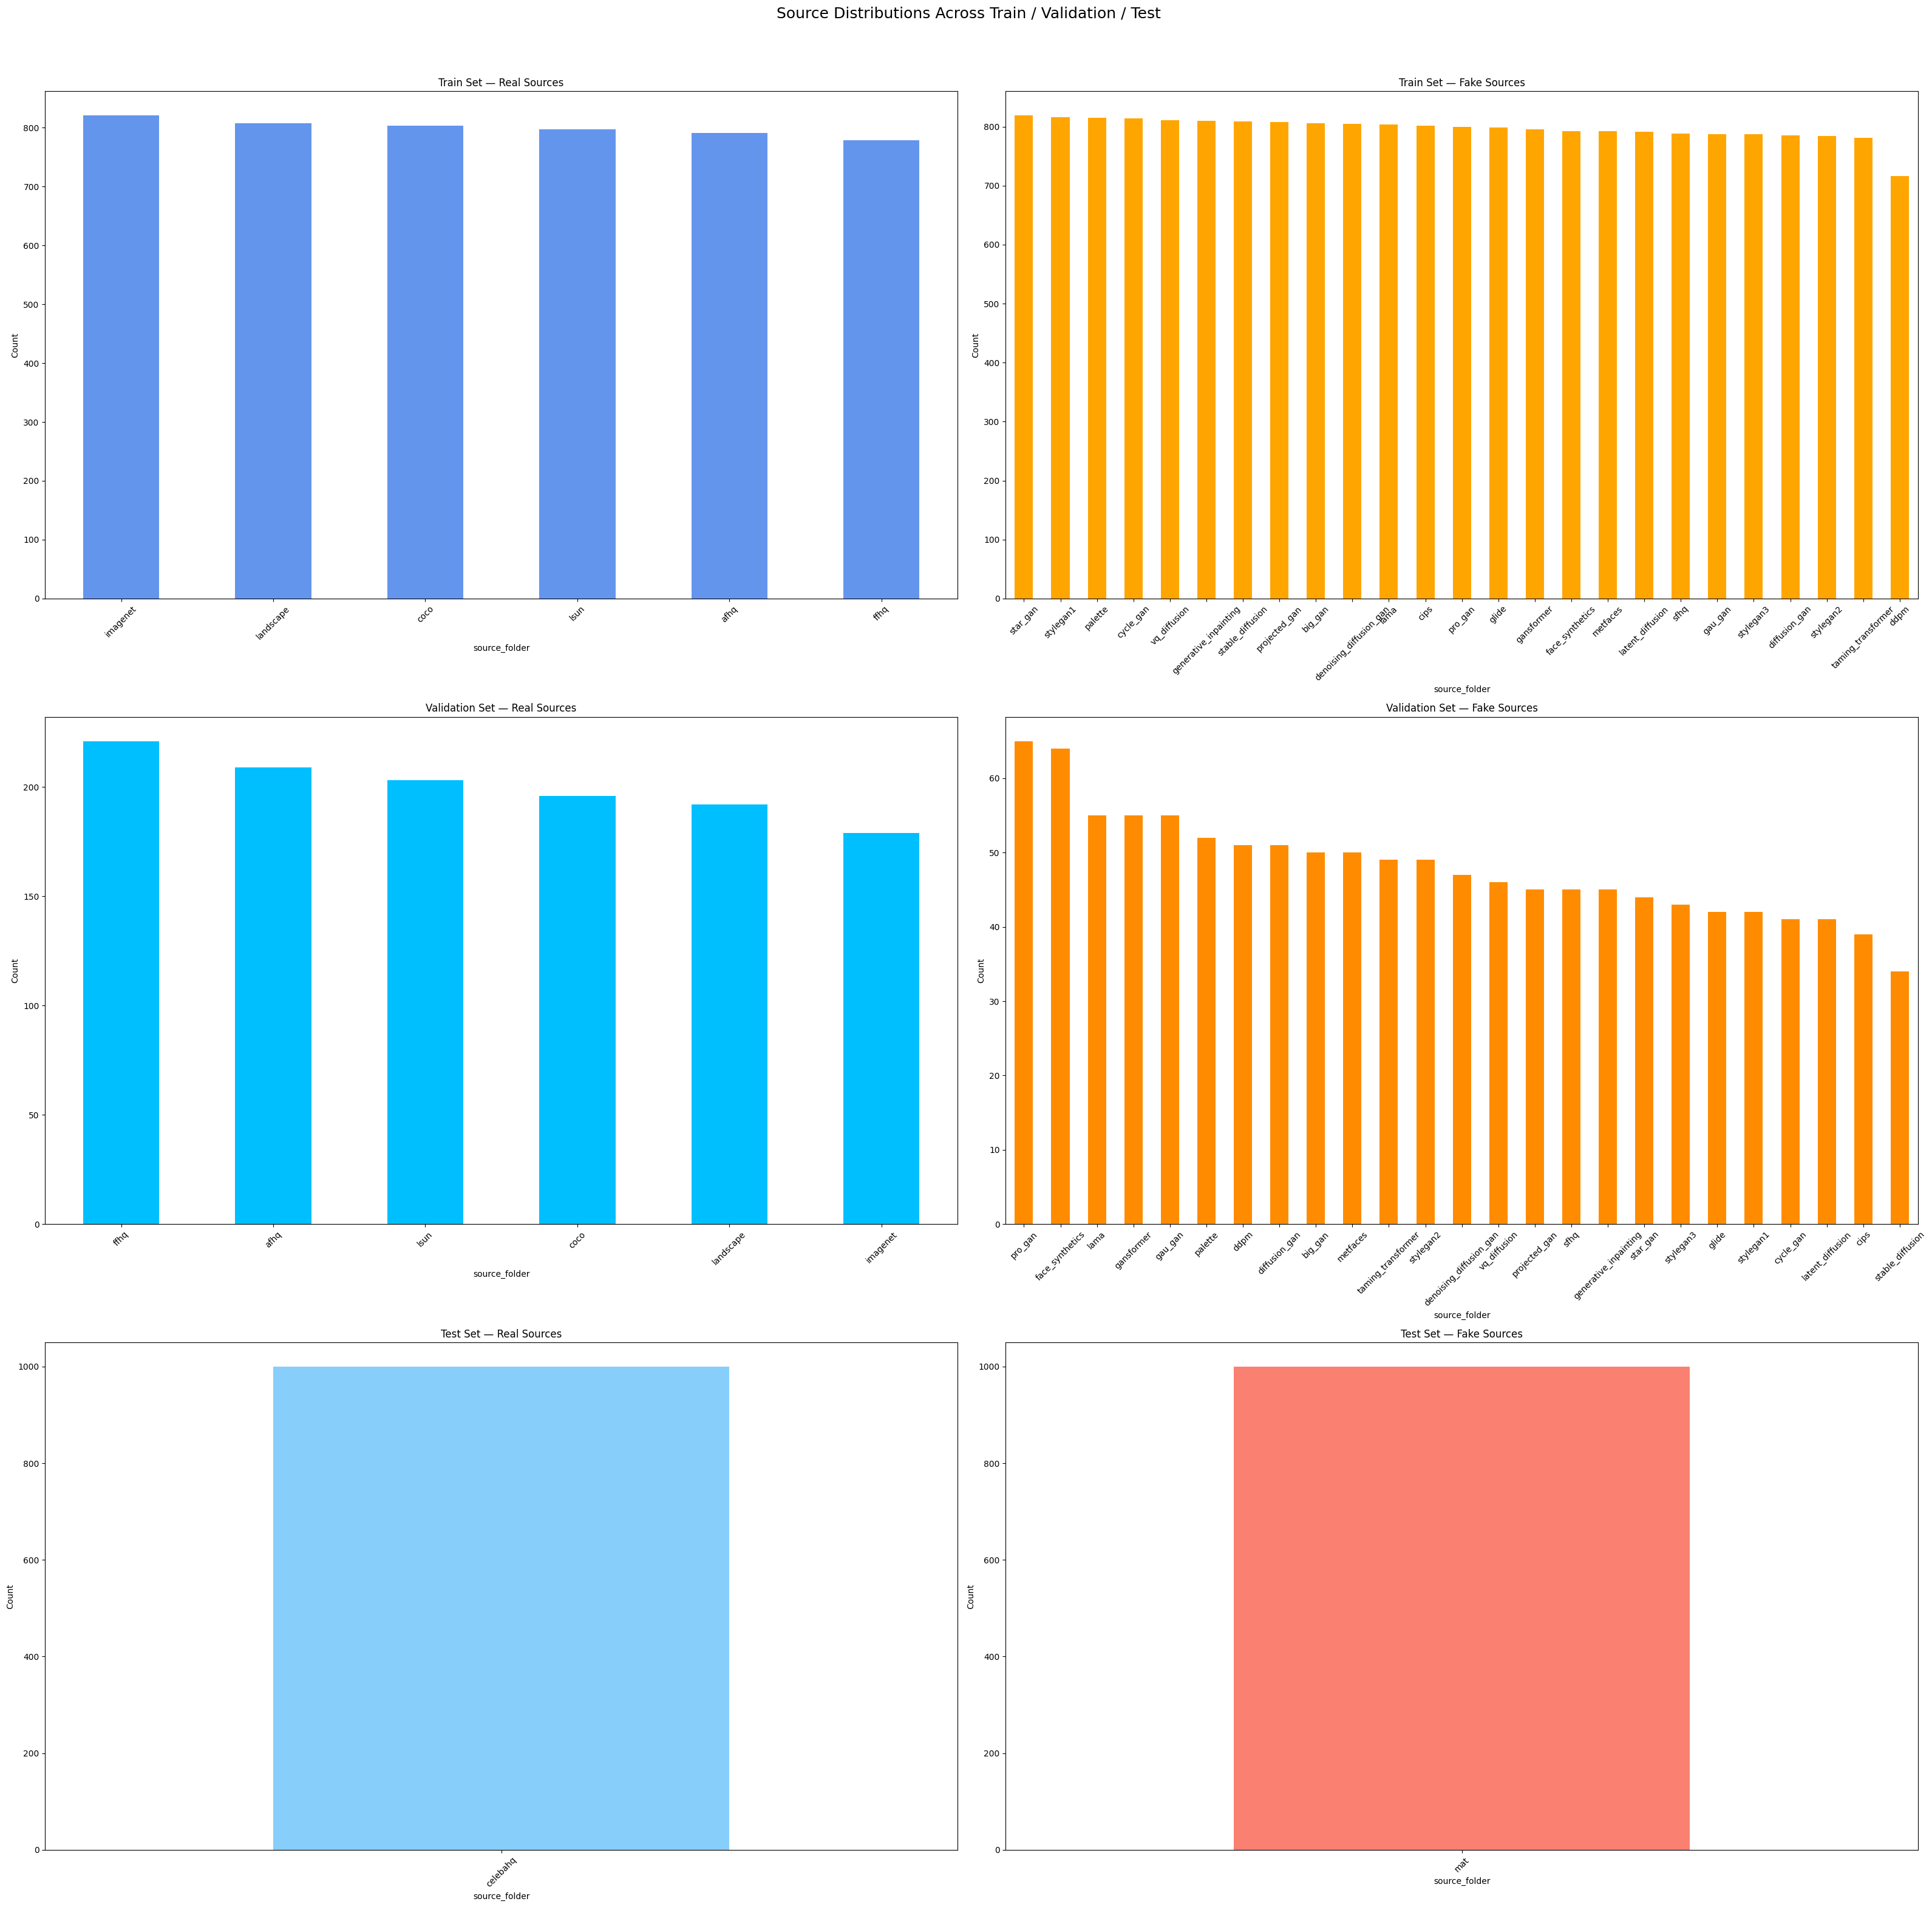

In [ ]:
real_sources = {'afhq', 'celebahq', 'coco', 'ffhq', 'imagenet', 'landscape', 'lsun', 'metafaces'}

train_real = train_df[train_df['source_folder'].str.lower().isin(real_sources)]
train_fake = train_df[~train_df['source_folder'].str.lower().isin(real_sources)]

val_real   = val_df[val_df['source_folder'].str.lower().isin(real_sources)]
val_fake   = val_df[~val_df['source_folder'].str.lower().isin(real_sources)]

test_real = test_real_df[test_real_df['source_folder'].str.lower().isin(real_sources)]
test_fake = test_fake_df[~test_fake_df['source_folder'].str.lower().isin(real_sources)]

train_real_counts = train_real['source_folder'].value_counts()
train_fake_counts = train_fake['source_folder'].value_counts()
val_real_counts   = val_real['source_folder'].value_counts()
val_fake_counts   = val_fake['source_folder'].value_counts()
test_real_counts  = test_real['source_folder'].value_counts()
test_fake_counts  = test_fake['source_folder'].value_counts()

fig, axs = plt.subplots(3, 2, figsize=(32, 32))

train_real_counts.plot(
    kind='bar', ax=axs[0, 0], color='cornflowerblue'
)
axs[0, 0].set_title('Train Set — Real Sources')
axs[0, 0].set_ylabel('Count')
axs[0, 0].tick_params(axis='x', rotation=45)

train_fake_counts.plot(
    kind='bar', ax=axs[0, 1], color='orange'
)
axs[0, 1].set_title('Train Set — Fake Sources')
axs[0, 1].set_ylabel('Count')
axs[0, 1].tick_params(axis='x', rotation=45)

val_real_counts.plot(
    kind='bar', ax=axs[1, 0], color='deepskyblue'
)
axs[1, 0].set_title('Validation Set — Real Sources')
axs[1, 0].set_ylabel('Count')
axs[1, 0].tick_params(axis='x', rotation=45)

val_fake_counts.plot(
    kind='bar', ax=axs[1, 1], color='darkorange'
)
axs[1, 1].set_title('Validation Set — Fake Sources')
axs[1, 1].set_ylabel('Count')
axs[1, 1].tick_params(axis='x', rotation=45)

test_real_counts.plot(
    kind='bar', ax=axs[2, 0], color='lightskyblue'
)
axs[2, 0].set_title('Test Set — Real Sources')
axs[2, 0].set_ylabel('Count')
axs[2, 0].tick_params(axis='x', rotation=45)

test_fake_counts.plot(
    kind='bar', ax=axs[2, 1], color='salmon'
)
axs[2, 1].set_title('Test Set — Fake Sources')
axs[2, 1].set_ylabel('Count')
axs[2, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Source Distributions Across Train / Validation / Test', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Figure 3.2.2.2 Real image source and fake image generator distirbution for Train, Validation, Test set

The resulting training set bar plots now show a uniform per-source distribution—each of the seven remaining real datasets (AFHQ, COCO, FFHQ, ImageNet, Landscape, LSUN, MetaFaces) and each fake generator contributes up to 1,000 images exactly, as intended. The validation set, after stratified splitting and perfect down-sampling, contains exactly 50% real and 50% fake examples: real examples remain capped per source and minor variations reflect the stratified split, but overall it’s tightly balanced. Finally, the test sets each comprise exactly 1,000 samples—one held-out real source (CelebA-HQ) and one unseen fake generator (MAT)—confirming that our pipeline produces correctly sized, domain-challenging splits for robust evaluation.

#### Consideration on Image Categories
In designing our data split strategy, we referred closely to the original ArtiFact paper. The authors randomly sampled real images from various source datasets and generated synthetic images targeting similar categories but did not balance the number of images across categories, nor did they address missing category labels. Therefore, we decided it was reasonable not to enforce category balancing between real and fake images, nor within training and validation splits. Additionally, while the paper emphasizes using fake images from unseen generators for testing to assess generalization, it does not require sourcing real images from unseen domains; real images from the same sources are allowed to appear in both training and testing. Based on these observations, we focused on ensuring that fake images in our validation set come from unseen generators while allowing real images to be drawn from the same sources as in training.

# 3. Model Selection and Justification:



To validate the model pipeline and ensure the training process was functional end-to-end, we first constructed a baseline model using a deliberately small and balanced dataset. This "sanity check" subset consisted of just 100 images (50 real and 50 fake), randomly sampled from the larger `train_df` and `val_df`. The dataset was evenly split between the two classes and harmonized via a basic torchvision preprocessing pipeline involving resizing and normalization.

We chose ResNet-18 trained from scratch (no pretrained weights) as the baseline architecture due to its simplicity, ease of debugging, and sufficient capacity to overfit a small dataset. Overfitting in this context was intentional as it served as proof that the model architecture, data pipeline, and optimization setup were working correctly.


### Model Architectures:

* An initial 7×7 convolution followed by max-pooling

* Four residual stages, each composed of BasicBlocks that use skip connections (F(x) + x)

* A global average pooling layer

* A final fully connected (FC) layer, replaced here with a binary (2-class) output layer

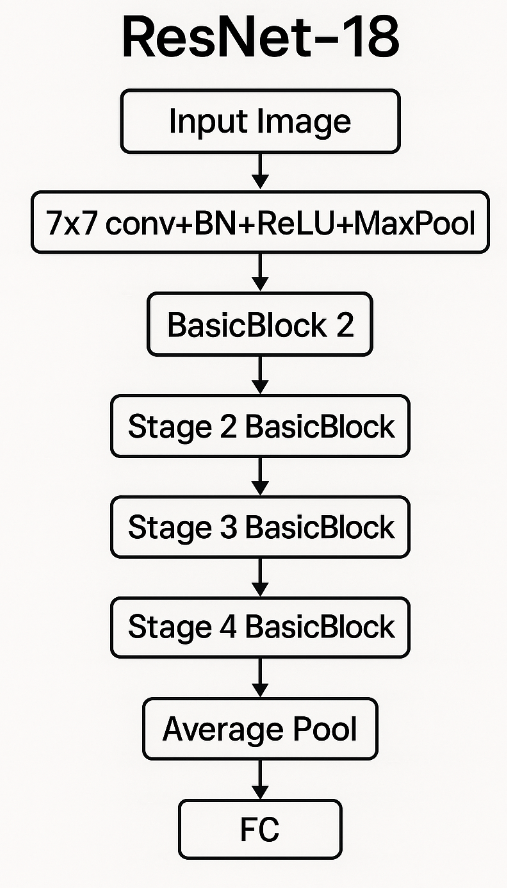

Figure 3.3.1 Architecture of baseline ResNet-18 Model

### Baseline Model Training

In [ ]:
# Imports
import os, random, pandas as pd, torch, torchvision
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam

RANDOM_STATE          = 42
TARGET_PER_CLASS      = 50
IMG_SIZE              = 224
BATCH_SIZE            = 8
EPOCHS                = 60
LR                    = 3e-3
device                = "cuda" if torch.cuda.is_available() else "cpu"

real_sources = {
    "afhq", "coco", "ffhq", "imagenet", "landscape", "lsun", "metfaces"
}

# Harmonise filepath column
if "image_path" in metadata.columns and "filepath" not in metadata.columns:
    metadata["filepath"] = (
        metadata["source_folder"].str.rstrip("/") + "/" + metadata["image_path"]
    )

# Build tiny (50-image) splits
def balanced_sample(df, n_per_class):
    real = df[df["source_folder"].str.lower().isin(real_sources)]             \
              .sample(n=n_per_class, random_state=RANDOM_STATE)
    fake = df[~df["source_folder"].str.lower().isin(real_sources)]            \
              .sample(n=n_per_class, random_state=RANDOM_STATE)
    return pd.concat([real, fake]).sample(frac=1, random_state=RANDOM_STATE)  \
             .reset_index(drop=True)

tiny_train = balanced_sample(train_df, TARGET_PER_CLASS)
tiny_val   = balanced_sample(val_df,   TARGET_PER_CLASS)

# Torch dataset/dataloader
class ArtifactDataset(Dataset):
    def __init__(self, df, img_root, tfms):
        self.paths  = df["filepath"].tolist()
        self.labels = df["source_folder"].str.lower().isin(real_sources)      \
                          .astype(int).tolist()
        self.img_root = img_root
        self.tfms = tfms
    def __len__(self):  return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_root, self.paths[idx]))        \
                 .convert("RGB")
        return self.tfms(img), torch.tensor(self.labels[idx], dtype=torch.long)

tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

train_ds = ArtifactDataset(tiny_train, dataset_path, tfms)
val_ds   = ArtifactDataset(tiny_val,   dataset_path, tfms)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE)

# ResNet-18 model (scratch)
model = torchvision.models.resnet18(weights=None)      # no pre-train
model.fc = nn.Linear(model.fc.in_features, 2)          # 2-class head
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=0.0)

# Training loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    tr_loss = 0; correct = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss   = criterion(logits, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        tr_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
    tr_acc = correct / len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
        val_correct = sum(
            (model(vx.to(device)).argmax(1) == vy.to(device)).sum().item()
            for vx, vy in val_dl
        )
    val_acc = val_correct / len(val_dl.dataset)

    print(f"Epoch {epoch:02d}: "
          f"train loss={tr_loss/len(train_dl.dataset):.4f} "
          f"train acc={tr_acc:.3%} | val acc={val_acc:.3%}")

    if tr_acc == 1.0: break        # stop when memorised the 50 images


Epoch 01: train loss=1.1302 train acc=56.000% | val acc=50.000%
Epoch 02: train loss=0.9267 train acc=53.000% | val acc=50.000%
Epoch 03: train loss=0.8048 train acc=51.000% | val acc=51.000%
Epoch 04: train loss=0.6888 train acc=59.000% | val acc=48.000%
Epoch 05: train loss=0.7449 train acc=52.000% | val acc=49.000%
Epoch 06: train loss=0.7669 train acc=62.000% | val acc=53.000%
Epoch 07: train loss=0.6859 train acc=60.000% | val acc=49.000%
Epoch 08: train loss=0.7325 train acc=62.000% | val acc=52.000%
Epoch 09: train loss=0.6799 train acc=57.000% | val acc=54.000%
Epoch 10: train loss=0.7271 train acc=52.000% | val acc=52.000%
Epoch 11: train loss=0.7435 train acc=53.000% | val acc=48.000%
Epoch 12: train loss=0.7886 train acc=53.000% | val acc=58.000%
Epoch 13: train loss=0.6391 train acc=61.000% | val acc=50.000%
Epoch 14: train loss=0.6659 train acc=62.000% | val acc=52.000%
Epoch 15: train loss=0.5939 train acc=63.000% | val acc=53.000%
Epoch 16: train loss=0.6552 train acc=62

The model successfully overfit the training data, indicating that the architecture and training loop worked as expected. However, the drop in validation accuracy highlighted overfitting and limited generalization, suggesting a need for deeper models, regularization, and a larger training set.

## Scaling the Baseline: ResNet-50 on Full Dataset

After verifying the setup, we scaled to a deeper and more expressive variant: ResNet-50. This version builds on the same residual architecture but replaces the BasicBlocks with Bottleneck blocks, which use a 1×1 → 3×3 → 1×1 convolution pattern. These blocks reduce dimensionality before the computationally expensive 3×3 convolution and restore it afterward, allowing ResNet-50 to be both deep and efficient.

We also initialized the model with ImageNet-pretrained weights to leverage generic low-level visual features. This allowed for faster convergence and better performance with limited data.

### Architecture Highlights:

* 50 layers deep

* Bottleneck residual blocks

* Global average pooling followed by a customized 2-class linear head

### Training Enhancements:

* Data Augmentation: RandomResizedCrop, ColorJitter, HorizontalFlip

* Label Smoothing (0.1) to improve calibration

* Optimizer: AdamW (weight_decay=1e-4)

* Learning rate scheduler: OneCycleLR

* Early stopping: patience = 4 epochs

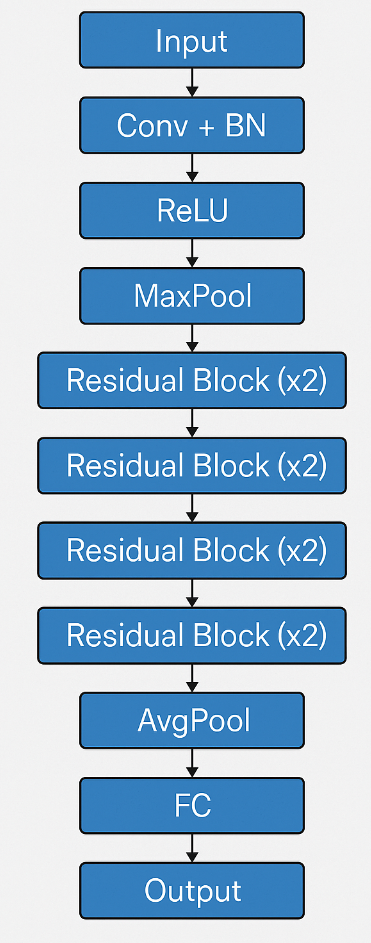

Figure 3.3.2 Architecture of scaled baseline ResNet-50 Model

In [ ]:
import time

device       = "cuda" if torch.cuda.is_available() else "cpu"
model_name   = "resnet50"
batch_size   = 64
epochs       = 25
lr_max       = 1e-4
weight_decay = 1e-4
patience     = 4
num_workers  = os.cpu_count() // 2

real_sources = {
    "afhq","coco","ffhq","imagenet","landscape","lsun","metfaces"
}

# Make sure file paths exist
if "image_path" in metadata.columns and "filepath" not in metadata.columns:
    metadata["filepath"] = (
        metadata["source_folder"].str.rstrip("/") + "/" + metadata["image_path"]
    )

# Dataset transformations
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std =(0.229,0.224,0.225)),
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406),
                         std =(0.229,0.224,0.225)),
])

class ArtifactDS(Dataset):
    def __init__(self, df, root, tfms):
        self.paths  = df["filepath"].tolist()
        self.labels = df["source_folder"].str.lower().isin(real_sources) \
                          .astype(int).tolist()
        self.root, self.tfms = root, tfms
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.paths[idx])) \
                  .convert("RGB")
        return self.tfms(img), self.labels[idx]

train_ds = ArtifactDS(train_df, dataset_path, train_tfms)
val_ds   = ArtifactDS(val_df,   dataset_path, val_tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size,
                      shuffle=True, num_workers=num_workers, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size,
                      shuffle=False,num_workers=num_workers, pin_memory=True)

# Model, loss, optimiser, scheduler
model = getattr(models, model_name)(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, 2)      # new head
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=lr_max, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, lr_max,
    steps_per_epoch=len(train_dl), epochs=epochs, pct_start=0.3
)

scaler = GradScaler()

# Train / validate loop with early-stop
best_acc, best_state, bad_epochs = 0.0, None, 0
for epoch in range(1, epochs+1):
    t0 = time.time()
    # ---- train ----
    model.train(); tr_loss=tr_correct=n_seen=0
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(x); loss = criterion(logits,y)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        sched.step()

        tr_loss   += loss.item()*x.size(0)
        tr_correct+= (logits.argmax(1)==y).sum().item()
        n_seen    += x.size(0)

    # ---- validate ----
    model.eval(); val_loss=val_correct=n_val=0
    with torch.no_grad(), autocast():
        for x,y in val_dl:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            loss   = criterion(logits,y)
            val_loss   += loss.item()*x.size(0)
            val_correct+= (logits.argmax(1)==y).sum().item()
            n_val      += x.size(0)

    tr_acc  = tr_correct  / n_seen
    val_acc = val_correct / n_val
    print(f"Ep {epoch:02d}/{epochs} | "
          f"tr_loss {tr_loss/n_seen:.4f}  acc {tr_acc:.3%} | "
          f"val_loss {val_loss/n_val:.4f}  acc {val_acc:.3%} | "
          f"{(time.time()-t0):.1f}s",
          flush=True)

    # ---- early-stop bookkeeping ----
    if val_acc > best_acc:
        best_acc, best_state = val_acc, model.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs > patience:
            print("⏹️  early stop"); break

# Load best weights & save
model.load_state_dict(best_state)
torch.save(model.state_dict(), "resnet_artifact_best.pt")
print(f"Best val acc: {best_acc:.3%}  ➔  weights saved to resnet_artifact_best.pt")

<ipython-input-43-8cbab7775421>:71: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()        # AMP for speed / VRAM
<ipython-input-43-8cbab7775421>:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-43-8cbab7775421>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Ep 01/25 | tr_loss 0.5678  acc 75.409% | val_loss 0.7339  acc 53.042% | 270.6s
Ep 02/25 | tr_loss 0.4896  acc 79.746% | val_loss 0.6734  acc 61.958% | 250.7s
Ep 03/25 | tr_loss 0.4498  acc 82.910% | val_loss 0.5743  acc 71.542% | 248.6s
Ep 04/25 | tr_loss 0.4181  acc 85.006% | val_loss 0.6117  acc 71.167% | 247.4s
Ep 05/25 | tr_loss 0.3890  acc 87.251% | val_loss 0.5245  acc 77.292% | 244.9s
Ep 06/25 | tr_loss 0.3638  acc 89.307% | val_loss 0.5246  acc 77.833% | 247.6s
Ep 07/25 | tr_loss 0.3438  acc 90.727% | val_loss 0.6372  acc 72.083% | 247.9s
Ep 08/25 | tr_loss 0.3219  acc 92.442% | val_loss 0.5331  acc 78.125% | 246.1s
Ep 09/25 | tr_loss 0.3058  acc 93.518% | val_loss 0.5439  acc 78.583% | 248.7s
Ep 10/25 | tr_loss 0.2851  acc 94.987% | val_loss 0.7008  acc 71.208% | 245.6s
Ep 11/25 | tr_loss 0.2761  acc 95.655% | val_loss 0.7299  acc 73.542% | 245.5s
Ep 12/25 | tr_loss 0.2643  acc 96.460% | val_loss 0.6670  acc 73.417% | 246.5s
Ep 13/25 | tr_loss 0.2551  acc 96.909% | val_loss 0.

In [ ]:
import os, torch, pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from PIL import Image
from torchvision import transforms, models
from torch.cuda.amp import autocast

# Combine the two test splits
test_df = pd.concat([test_real_df, test_fake_df]).reset_index(drop=True)

# ensure there is a 'filepath' column
if "image_path" in test_df.columns and "filepath" not in test_df.columns:
    test_df["filepath"] = test_df["source_folder"].str.rstrip("/") + "/" + test_df["image_path"]

# Define a robust Dataset class
class ArtifactDS(Dataset):
    """
    If the dataframe already has a 'label' column (0/1), we'll use it.
    Otherwise we compute labels using the supplied real_src_set.
    """
    def __init__(self, df, root, tfms, real_src_set):
        self.paths  = df["filepath"].tolist()
        if "label" in df.columns:
            self.labels = df["label"].tolist()
        else:
            self.labels = df["source_folder"].str.lower().isin(real_src_set) \
                              .astype(int).tolist()
        self.root, self.tfms = root, tfms
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.paths[idx])).convert("RGB")
        return self.tfms(img), self.labels[idx]

# Build the test DataLoader
real_sources_test = real_sources | {TEST_REAL_SOURCE}

test_ds = ArtifactDS(test_df, dataset_path, val_tfms, real_sources_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                     num_workers=num_workers, pin_memory=True)

# Re-create the trained model & load weights
device = "cuda" if torch.cuda.is_available() else "cpu"

model = getattr(models, model_name)(weights="IMAGENET1K_V2")
model.fc = nn.Linear(model.fc.in_features, 2)           # SAME head as training
model.to(device)

ckpt = torch.load("resnet_artifact_best.pt", map_location=device)
model.load_state_dict(ckpt)
model.eval()

# Inference loop
all_preds, all_gts = [], []
with torch.no_grad(), autocast():
    for x, y in tqdm(test_dl, desc="Testing"):
        logits = model(x.to(device))
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_gts.append(np.array(y))

all_preds = np.concatenate(all_preds)
all_gts   = np.concatenate(all_gts)

# Metrics
overall_acc = (all_preds == all_gts).mean() * 100
print(f"\nOverall test accuracy: {overall_acc:.2f} %")

for cls, name in enumerate(["fake", "real"]):
    cls_acc = (all_preds[all_gts == cls] == cls).mean() * 100
    print(f"{name:>4} accuracy: {cls_acc:.2f} %")

cm = confusion_matrix(all_gts, all_preds, labels=[0,1])
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification report:")
print(classification_report(all_gts, all_preds,
                            target_names=["fake","real"], digits=3))

<ipython-input-47-976e416b1580>:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Testing:   0%|          | 0/32 [00:00<?, ?it/s]


Overall test accuracy: 56.45 %
fake accuracy: 79.30 %
real accuracy: 33.60 %

Confusion matrix (rows=true, cols=pred):
[[793 207]
 [664 336]]

Classification report:
              precision    recall  f1-score   support

        fake      0.544     0.793     0.646      1000
        real      0.619     0.336     0.436      1000

    accuracy                          0.565      2000
   macro avg      0.582     0.565     0.541      2000
weighted avg      0.582     0.565     0.541      2000



While ResNet-50 achieved strong validation accuracy, the test results revealed an imbalance: excellent detection of fake images but poor generalization to real ones. This may reflect dataset imbalance, lack of nuanced real image diversity, or insufficient model expressivity for subtler “real” artifacts.

## Improved Model: ConvNeXt-Tiny with Advanced Regularization

To address ResNet's limitations, we turned to ConvNeXt-Tiny, a recent convolutional architecture inspired by Vision Transformers (ViTs) but retaining the computational efficiency of CNNs. ConvNeXt integrates best practices from both CNNs and transformers, achieving high accuracy with robust generalization.

### Architectural Innovations in ConvNeXt-Tiny:

* Depthwise Separable Convolutions: Large 7×7 depthwise convolutions replace traditional 3×3 filters, expanding receptive fields without increasing parameter count.

* Inverted Bottleneck Design: Feature expansion followed by projection, similar to MobileNetV2 and transformer feedforward layers.

* Layer Normalization: Replaces BatchNorm for better stability, especially in mixed precision and small batch training.

* GELU Activation: Smoother than ReLU, improves gradient flow.

* Patch-based Downsampling: Hierarchical stages mimic transformer-like scaling.

### Training Configuration:

* Optimizer: AdamW

* Loss: CrossEntropy with label smoothing

* Learning Rate Scheduler: CosineAnnealingLR

* Early stopping with patience=6

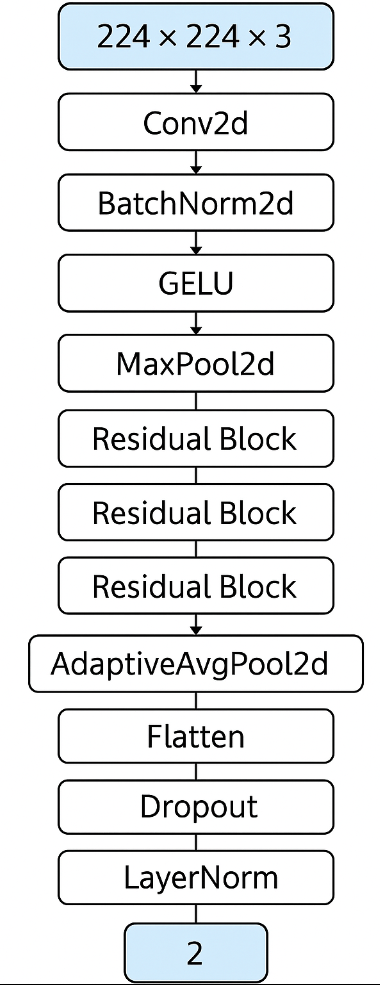

Figure 3.3.3 Architecture of ConvNeXt-Tiny Model

In [ ]:
# imports & globals
import os, time, torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchvision import transforms, models
from PIL import Image

device       = "cuda" if torch.cuda.is_available() else "cpu"
batch_size   = 64
epochs       = 30
lr_max       = 3e-5
weight_decay = 1e-4
patience     = 6
num_workers  = os.cpu_count() // 2

real_sources = {"afhq","coco","ffhq","imagenet","landscape","lsun","metfaces"}

# ensure filepath column
if "image_path" in metadata.columns and "filepath" not in metadata.columns:
    metadata["filepath"] = metadata["source_folder"].str.rstrip("/") + "/" + metadata["image_path"]

# transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225)),
])

class ArtifactDS(Dataset):
    def __init__(self, df, root, tfms):
        self.paths  = df["filepath"].tolist()
        self.labels = df["source_folder"].str.lower().isin(real_sources).astype(int).tolist()
        self.root, self.tfms = root, tfms
    def __len__(self):  return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.paths[idx])).convert("RGB")
        return self.tfms(img), self.labels[idx]

train_ds = ArtifactDS(train_df, dataset_path, train_tfms)
val_ds   = ArtifactDS(val_df,   dataset_path, val_tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                      num_workers=num_workers, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                      num_workers=num_workers, pin_memory=True)

# improved ConvNeXt-Tiny model
backbone = models.convnext_tiny(weights="IMAGENET1K_V1")
in_feats = backbone.classifier[-1].in_features            # 768

backbone.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),       # ↓ output: [B, 768, 1, 1]
    nn.Flatten(1),                 # → [B, 768]
    nn.Dropout(0.3),
    nn.LayerNorm(in_feats),
    nn.Linear(in_feats, 2)
)
model = backbone.to(device)

# loss, optimiser, scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=epochs*len(train_dl), eta_min=1e-6
)
scaler = GradScaler()

# train / validate loop
best_acc = 0.0; best_state = None; bad_epochs = 0
for epoch in range(1, epochs+1):
    t0 = time.time()
    # ---- train ----
    model.train(); tr_loss=tr_correct=n_seen=0
    for x,y in train_dl:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast():
            logits = model(x); loss = criterion(logits,y)
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        sched.step()

        tr_loss   += loss.item()*x.size(0)
        tr_correct+= (logits.argmax(1)==y).sum().item()
        n_seen    += x.size(0)

    # ---- validate ----
    model.eval(); val_loss=val_correct=n_val=0
    with torch.no_grad(), autocast():
        for x,y in val_dl:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            loss   = criterion(logits,y)
            val_loss   += loss.item()*x.size(0)
            val_correct+= (logits.argmax(1)==y).sum().item()
            n_val      += x.size(0)

    tr_acc  = tr_correct / n_seen
    val_acc = val_correct / n_val
    print(f"Ep {epoch:02d}/{epochs} | "
          f"tr_loss {tr_loss/n_seen:.4f}  acc {tr_acc:.3%} | "
          f"val_loss {val_loss/n_val:.4f}  acc {val_acc:.3%} | "
          f"{(time.time()-t0):.1f}s", flush=True)

    # ---- early stop ----
    if val_acc > best_acc:
        best_acc, best_state = val_acc, model.state_dict()
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs > patience:
            print("⏹️  early stop"); break

# save best model
model.load_state_dict(best_state)
torch.save(model.state_dict(), "convnext_artifact_best.pt")
print(f"Best val acc: {best_acc:.3%}  ➔  weights saved to convnext_artifact_best.pt")


<ipython-input-30-117503759fd6>:74: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-30-117503759fd6>:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
<ipython-input-30-117503759fd6>:97: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` inste

Ep 01/30 | tr_loss 0.5057  acc 79.515% | val_loss 0.6489  acc 67.667% | 266.0s
Ep 02/30 | tr_loss 0.4397  acc 83.901% | val_loss 0.6583  acc 69.083% | 264.8s
Ep 03/30 | tr_loss 0.4106  acc 86.033% | val_loss 0.5860  acc 73.625% | 262.0s
Ep 04/30 | tr_loss 0.3820  acc 88.303% | val_loss 0.5370  acc 77.792% | 270.2s
Ep 05/30 | tr_loss 0.3594  acc 89.735% | val_loss 0.4791  acc 82.667% | 260.1s
Ep 06/30 | tr_loss 0.3367  acc 91.548% | val_loss 0.6474  acc 75.375% | 261.2s
Ep 07/30 | tr_loss 0.3151  acc 93.089% | val_loss 0.5401  acc 79.667% | 261.3s
Ep 08/30 | tr_loss 0.2988  acc 94.218% | val_loss 0.5788  acc 78.417% | 260.6s
Ep 09/30 | tr_loss 0.2859  acc 95.133% | val_loss 0.5838  acc 78.583% | 261.1s
Ep 10/30 | tr_loss 0.2747  acc 95.732% | val_loss 0.6760  acc 76.042% | 262.0s
Ep 11/30 | tr_loss 0.2659  acc 96.351% | val_loss 0.6063  acc 78.292% | 262.6s
Ep 12/30 | tr_loss 0.2557  acc 96.957% | val_loss 0.5453  acc 81.458% | 261.0s
⏹️  early stop
Best val acc: 82.667%  ➔  weights sav

### ConvNeXt-Tiny Test

In [ ]:
import os, torch, numpy as np, pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

# Build & prepare test DataFrame
test_df = pd.concat([test_real_df, test_fake_df], ignore_index=True).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
if "image_path" in test_df.columns and "filepath" not in test_df.columns:
    test_df["filepath"] = test_df["source_folder"].str.rstrip("/") + "/" + test_df["image_path"]

# Dataset / DataLoader
class ArtifactTestDS(Dataset):
    def __init__(self, df, root, tfms, real_src):
        self.paths  = df["filepath"].tolist()
        self.labels = df["source_folder"].str.lower().isin(real_src).astype(int).tolist()
        self.root, self.tfms = root, tfms
    def __len__(self):  return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.paths[idx])).convert("RGB")
        return self.tfms(img), self.labels[idx]

real_sources_test = real_sources | {TEST_REAL_SOURCE}
test_ds = ArtifactTestDS(test_df, dataset_path, val_tfms, real_sources_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                     num_workers=num_workers, pin_memory=True)

# Load your best model
device = "cuda" if torch.cuda.is_available() else "cpu"
backbone = models.convnext_tiny(weights=None)      # no pretrained head
in_feats  = backbone.classifier[-1].in_features
backbone.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(1),
    nn.Dropout(0.3),
    nn.LayerNorm(in_feats),
    nn.Linear(in_feats, 2)
)
model = backbone.to(device)
model.load_state_dict(torch.load("convnext_artifact_best.pt", map_location=device))
model.eval()

# Inference & metrics
all_preds, all_gts = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        logits = model(xb)
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_gts.append(np.array(yb))

all_preds = np.concatenate(all_preds)
all_gts   = np.concatenate(all_gts)

acc = (all_preds == all_gts).mean()
print(f"Test accuracy: {acc*100:.2f}%\n")

# Per‐class and confusion matrix
print("Classification report:\n",
      classification_report(all_gts, all_preds, target_names=["fake","real"], digits=4))
print("Confusion matrix:\n",
      confusion_matrix(all_gts, all_preds, labels=[0,1]))


Test accuracy: 63.90%

Classification report:
               precision    recall  f1-score   support

        fake     0.5963    0.8610    0.7046      1000
        real     0.7500    0.4170    0.5360      1000

    accuracy                         0.6390      2000
   macro avg     0.6731    0.6390    0.6203      2000
weighted avg     0.6731    0.6390    0.6203      2000

Confusion matrix:
 [[861 139]
 [583 417]]


Compared to ResNet-50, ConvNeXt significantly improved generalization, especially on the "real" class, though class imbalance remained. This performance gain can be attributed to both architectural innovations and more aggressive regularization techniques.

## Domain-Adversarial Model: DANN-ResNet50 with Gradient Reversal

To improve generalization to unseen domains (e.g., CelebA-HQ, MAT), we implemented a Domain-Adversarial Neural Network (DANN) architecture based on ResNet-50. This model extends the standard ResNet classifier by incorporating a domain classifier head and a gradient reversal layer (GRL), allowing it to learn domain-invariant features.

Rather than only minimizing classification loss on the training domains, DANN explicitly encourages the model to fool a domain classifier, thereby removing domain-specific cues from the learned features. This structure is particularly beneficial in settings with multi-source training and unseen target domains, where standard supervised training may lead to overfitting to source-specific artifacts.

###Architecture Overview:

- Backbone: ResNet-50 with ImageNet-pretrained weights
- Class Head: 2-class linear classifier (real vs. fake)
- Domain Head: Multi-class domain classifier (domain for real = data source, domain for fake = generator)
- Gradient Reversal Layer: Applied before domain head to invert gradients

Diagram citation: DANN model by Ganin et al., 2016

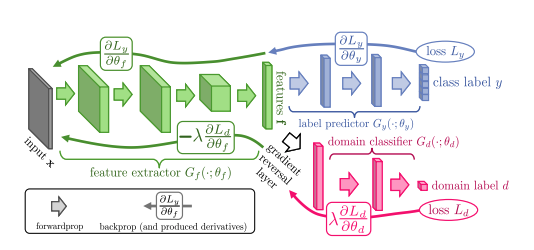

Figure 3.3.4 Architecture of DANN-ResNet50 with Gradient Reversal Model

###Key Design Principles:

- Feature Sharing: Both heads operate on shared ResNet features.
- Adversarial Training: The gradient reversal layer encourages the feature extractor to generate domain-invariant representations.
- Single Pass: Both losses are computed in the same forward-backward pass for efficiency.

###Training Strategy:

- Class Loss: CrossEntropy on real-vs-fake labels for all training domains
- Domain Loss: CrossEntropy on domain labels (source_folder)
- Loss Composition: Final loss = class loss + domain loss
- Alpha Scheduling: The gradient reversal strength increases with training progress (α = 2 / (1 + exp(-10p)) - 1)
- Data Augmentation: RandomResizedCrop, ColorJitter, HorizontalFlip
- Optimizer: AdamW (weight_decay = 1e-4)
- Learning Rate Scheduler: OneCycleLR
- Mixed Precision: AMP enabled with GradScaler
- Early Stopping: Patience = 4 epochs

In [ ]:
import os
import time
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast
from torch.autograd import Function
import numpy as np

# ─── Reverse Gradient Layer ─────────────────────────────────────────────
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

# ─── DANN ResNet Wrapper ─────────────────────────────────────────────────
class DANNResNet(nn.Module):
    def __init__(self, base_model_name="resnet50", num_domains=31):
        super().__init__()
        base = getattr(models, base_model_name)(weights="IMAGENET1K_V2")
        self.feature_extractor = nn.Sequential(*list(base.children())[:-1])
        self.feature_dim = base.fc.in_features

        self.class_classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 100), nn.ReLU(),
            nn.Linear(100, 2)  # real vs fake
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 100), nn.ReLU(),
            nn.Linear(100, num_domains)
        )

    def forward(self, x, alpha=0):
        features = self.feature_extractor(x).view(x.size(0), -1)
        reverse_features = ReverseLayerF.apply(features, alpha)
        class_logits = self.class_classifier(features)
        domain_logits = self.domain_classifier(reverse_features)
        return class_logits, domain_logits

# ─── Custom Dataset ──────────────────────────────────────────────────────
class ArtifactDomainDataset(Dataset):
    def __init__(self, df, root, tfms, domain_to_idx, real_sources):
        self.paths = df["filepath"].tolist()
        self.labels = df["source_folder"].str.lower().isin(real_sources).astype(int).tolist()
        self.domains = df["source_folder"].str.lower().map(domain_to_idx).astype(int).tolist()
        self.root, self.tfms = root, tfms

    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.paths[idx])).convert("RGB")
        x = self.tfms(img)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        d = torch.tensor(self.domains[idx], dtype=torch.long)
        return x, y, d

# ─── Training Setup ──────────────────────────────────────────────────────
def train_dann_resnet(train_df, val_df, dataset_path, real_sources,
                      model_name="resnet50", batch_size=64, epochs=25,
                      lr=1e-4, weight_decay=1e-4, patience=4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = os.cpu_count() // 2

    # Build domain map
    all_domains = pd.concat([train_df, val_df])["source_folder"].str.lower().unique()
    domain_to_idx = {d: i for i, d in enumerate(sorted(all_domains))}

    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6,1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4,0.4,0.4,0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ])
    val_tfms = transforms.Compose([
        transforms.Resize(256), transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
    ])

    train_ds = ArtifactDomainDataset(train_df, dataset_path, train_tfms, domain_to_idx, real_sources)
    val_ds   = ArtifactDomainDataset(val_df, dataset_path, val_tfms, domain_to_idx, real_sources)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_dl   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    model = DANNResNet(model_name, num_domains=len(domain_to_idx)).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
        steps_per_epoch=len(train_dl), epochs=epochs, pct_start=0.3)

    criterion_class = nn.CrossEntropyLoss()
    criterion_domain = nn.CrossEntropyLoss()
    scaler = GradScaler()

    best_acc, best_state, bad_epochs = 0.0, None, 0
    for epoch in range(1, epochs + 1):
        t0 = time.time()
        model.train(); tr_correct=n_seen=tr_loss_c=tr_loss_d=0

        for i, (x, y, d) in enumerate(train_dl):
            p = float(i + epoch * len(train_dl)) / (epochs * len(train_dl))
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            x, y, d = x.to(device), y.to(device), d.to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast():
                out_c, out_d = model(x, alpha)
                loss_c = criterion_class(out_c, y)
                loss_d = criterion_domain(out_d, d)
                loss = loss_c + loss_d

            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
            scheduler.step()

            tr_correct += (out_c.argmax(1) == y).sum().item()
            n_seen += x.size(0)
            tr_loss_c += loss_c.item() * x.size(0)
            tr_loss_d += loss_d.item() * x.size(0)

        tr_acc = tr_correct / n_seen

        model.eval(); val_correct=n_val=0
        with torch.no_grad(), autocast():
            for x, y, _ in val_dl:
                x, y = x.to(device), y.to(device)
                out_c, _ = model(x, alpha=0)
                val_correct += (out_c.argmax(1) == y).sum().item()
                n_val += x.size(0)
        val_acc = val_correct / n_val

        print(f"Ep {epoch:02d}/{epochs} | "
              f"tr_loss_cls {tr_loss_c/n_seen:.4f} dom {tr_loss_d/n_seen:.4f}  acc {tr_acc:.3%} | "
              f"val acc {val_acc:.3%} | {(time.time()-t0):.1f}s", flush=True)

        if val_acc > best_acc:
            best_acc, best_state = val_acc, model.state_dict()
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs > patience:
                print("⏹️  early stop"); break

    model.load_state_dict(best_state)
    torch.save(model.state_dict(), f"dann_{model_name}_best.pt")
    print(f"Best val acc: {best_acc:.3%}  ➔  weights saved to dann_{model_name}_best.pt")


In [ ]:
train_dann_resnet(
    train_df=train_df,
    val_df=val_df,
    dataset_path=dataset_path,
    real_sources={"afhq", "coco", "ffhq", "imagenet", "landscape", "lsun", "metfaces"},
    model_name="resnet50",
    batch_size=64,
    epochs=25,
    lr=1e-4,
    weight_decay=1e-4,
    patience=4
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]
<ipython-input-6-d8de36fdc339>:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-d8de36fdc339>:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-6-d8de36fdc339>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Ep 01/25 | tr_loss_cls 0.5600 dom 3.4265  acc 75.190% | val acc 48.042% | 283.6s
Ep 02/25 | tr_loss_cls 0.4368 dom 3.4000  acc 77.565% | val acc 53.042% | 257.6s
Ep 03/25 | tr_loss_cls 0.3914 dom 3.4275  acc 81.235% | val acc 64.208% | 258.2s
Ep 04/25 | tr_loss_cls 0.3554 dom 3.4501  acc 83.808% | val acc 74.000% | 255.6s
Ep 05/25 | tr_loss_cls 0.3244 dom 3.4220  acc 85.435% | val acc 70.833% | 256.9s
Ep 06/25 | tr_loss_cls 0.3055 dom 3.3918  acc 86.790% | val acc 69.125% | 254.4s
Ep 07/25 | tr_loss_cls 0.3000 dom 3.3685  acc 87.154% | val acc 67.667% | 255.2s
Ep 08/25 | tr_loss_cls 0.3396 dom 3.3654  acc 86.381% | val acc 71.958% | 252.0s
Ep 09/25 | tr_loss_cls 0.3254 dom 3.3367  acc 86.697% | val acc 75.458% | 255.4s
Ep 10/25 | tr_loss_cls 0.2917 dom 3.3577  acc 87.923% | val acc 62.958% | 257.5s
Ep 11/25 | tr_loss_cls 0.2708 dom 3.3474  acc 89.027% | val acc 78.333% | 257.2s
Ep 12/25 | tr_loss_cls 0.2650 dom 3.3463  acc 89.731% | val acc 75.708% | 254.8s
Ep 13/25 | tr_loss_cls 0.245

In [ ]:
import os, torch, pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from PIL import Image
from torchvision import transforms
from torch.cuda.amp import autocast

test_df = pd.concat([test_real_df, test_fake_df]).reset_index(drop=True)

# ensure there is a 'filepath' column
if "image_path" in test_df.columns and "filepath" not in test_df.columns:
    test_df["filepath"] = (
        test_df["source_folder"].str.rstrip("/") + "/" + test_df["image_path"]
    )

class ArtifactDS(Dataset):
    def __init__(self, df, root, tfms, real_src_set):
        self.paths  = df["filepath"].tolist()
        self.labels = df["source_folder"].str.lower().isin(real_src_set).astype(int).tolist()
        self.root, self.tfms = root, tfms
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.paths[idx])).convert("RGB")
        return self.tfms(img), self.labels[idx]

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

real_sources_test = {TEST_REAL_SOURCE}

test_ds = ArtifactDS(test_df, dataset_path, val_tfms, real_sources_test)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False,
                     num_workers=1, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DANNResNet()
model.load_state_dict(torch.load("dann_resnet50_best.pt", map_location=device))
model.to(device)
model.eval()

all_preds, all_gts = [], []
with torch.no_grad(), autocast():
    for x, y in tqdm(test_dl, desc="Testing"):
        out_class, _ = model(x.to(device), alpha=0)
        all_preds.append(out_class.argmax(1).cpu().numpy())
        all_gts.append(np.array(y))

all_preds = np.concatenate(all_preds)
all_gts   = np.concatenate(all_gts)

overall_acc = (all_preds == all_gts).mean() * 100
print(f"\nOverall test accuracy: {overall_acc:.2f} %")

for cls, name in enumerate(["fake", "real"]):
    cls_acc = (all_preds[all_gts == cls] == cls).mean() * 100
    print(f"{name:>4} accuracy: {cls_acc:.2f} %")

cm = confusion_matrix(all_gts, all_preds, labels=[0,1])
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

print("\nClassification report:")
print(classification_report(all_gts, all_preds,
                            target_names=["fake","real"], digits=3))


<ipython-input-8-21766762b09f>:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Testing:   0%|          | 0/32 [00:00<?, ?it/s]


Overall test accuracy: 51.75 %
fake accuracy: 86.90 %
real accuracy: 16.60 %

Confusion matrix (rows=true, cols=pred):
[[869 131]
 [834 166]]

Classification report:
              precision    recall  f1-score   support

        fake      0.510     0.869     0.643      1000
        real      0.559     0.166     0.256      1000

    accuracy                          0.517      2000
   macro avg      0.535     0.517     0.449      2000
weighted avg      0.535     0.517     0.449      2000



Although the model demonstrated adequate learning on the training set (93%) and acceptable validation accuracy (78%), this did not translate into robust generalization on the test set. This indicates that the training pipeline itself is correctly implemented — the model is learning — but its learned representations are not generalizing to new domains.

Several factors may explain the significant generalization gap:
- While DANN can promote domain invariance, it can also suppress class-discriminative signals if not carefully balanced. In this case, minimizing domain classification loss may have come at the cost of learning fine-grained features needed to distinguish real vs. fake in the test set.
- The test set (CelebA-HQ and MAT) may be too different from training domains — especially in terms of image resolution, compression artifacts, or generation style. DANN can struggle when the target domain is far out-of-distribution from all sources.
- Domain classifier may be too strong or too weak. If the domain classifier is too accurate, the GRL signal can destabilize training. If it’s too weak, the feature extractor may ignore the GRL signal altogether.

We will provide potential next steps in the next section.

# 4. Results and Future Work:



## Conclusion


### Final Comparison

We evaluated three models on the real-vs-fake classification task across unseen domains (CelebA-HQ and MAT): a baseline ResNet-50 classifier, a ConvNeXt-Tiny model with modern architectural improvements, and a domain-adversarial ResNet-50 (DANN) designed to promote domain-invariant features.

| Model              | Overall Acc | Fake Acc | Real Acc | Macro F1 | Observations                           |
|-------------------|-------------|----------|----------|----------|----------------------------------------|
| **Baseline (ResNet-50)** | 56.45%      | 79.30%   | 33.60%   | 0.541    | Biased toward fake, weak generalization |
| **ConvNeXt-Tiny**        | **63.90%**  | 86.10%   | **41.70%**   | **0.620**    | Strongest overall generalization         |
| **DANN-ResNet-50**       | 51.75%      | **86.90%**   | 16.60%   | 0.449    | Best fake recall, worst real generalization |

### Key Takeaways

- **ConvNeXt-Tiny outperformed both ResNet-50 and DANN-ResNet-50** in all key metrics, particularly in macro F1 and real class recall. Its architectural advancements and stronger inductive biases likely helped it generalize better to the real test domain.
  
- **The baseline ResNet-50 showed moderate performance**, with a strong bias toward the fake class. While it could detect fake images with reasonable precision, it struggled to correctly classify real images from unseen domains.

- **DANN-ResNet-50, despite its goal of domain invariance, underperformed**, particularly on the real class (16.6% recall). While it achieved the highest fake accuracy (86.9%), its overall classification balance was poor. This suggests that while the model learned to suppress domain-specific cues, it may have also weakened class-discriminative features necessary for real/fake separation.

### Conclusion

Although domain-adversarial training holds theoretical appeal, in this setting it underperformed compared to simpler supervised training and ConvNeXt's modern convolutional architecture. The results highlight that **balancing domain invariance with class discrimination remains challenging**, and that **architectural strength and regularization may be more effective than adversarial learning** under certain data conditions.

## Limitations

Despite experimenting with a variety of architectures and training strategies, several limitations emerged that impacted overall model performance and generalization:

### Baseline ResNet-50

- **Bias toward the fake class**: The baseline model achieved relatively high fake accuracy but poor real image classification, suggesting that it overfit to artifact-like patterns common in fake generators.
- **Limited robustness to domain shift**: Performance dropped substantially on real images from the unseen CelebA-HQ domain, highlighting poor generalization to new distributions despite supervised training.

### ConvNeXt-Tiny

- **High model complexity**: While ConvNeXt-Tiny performed best overall, its training was more computationally expensive and sensitive to learning rate schedules and regularization.
- **Underfitting of real class**: Although improved, real image recall (41.7%) remained lower than ideal, indicating the model still struggles to learn diverse real-world features.

### DANN-ResNet-50

- **Poor real class generalization**: Despite its goal of domain invariance, the DANN model had the lowest recall for real images (16.6%), suggesting the adversarial signal may have disrupted class-discriminative features.
- **Complex training dynamics**: The gradient reversal setup introduces non-obvious interactions between domain and class branches, making debugging and convergence harder compared to standard models.

## Future Work

To address the limitations observed in our current models, several future directions are proposed:

### 1. **Improved Domain Generalization Techniques**
- Explore methods like **MixStyle**, **SWAD (Stochastic Weight Averaged DNNs)**, or **CORAL** to promote domain-invariant features without adversarial training.
- Consider **test-time adaptation** strategies to fine-tune the model during inference based on target distribution statistics.

### 2. **More Realistic and Diverse Real Training Data**
- Incorporate a wider variety of real image sources beyond the original 7 to better match test-time diversity (e.g., CelebA-HQ).
- Use **data synthesis or augmentation** techniques to simulate lighting, compression, and cropping artifacts found in real-world data.

### 3. **Architectural Improvements**
- Evaluate lighter, more flexible backbones like **EfficientNet** or **ConvNeXt-V2**, which may offer a better trade-off between accuracy and domain robustness.
- Consider combining **CNN backbones with attention mechanisms** (e.g., hybrid CNN-transformer models) to better capture high-level semantic features.

### 4. **Balanced and Curriculum-Based Training**
- Experiment with **curriculum learning**, where simpler or more similar domains are introduced first before mixing all sources.
- Use **domain-aware sampling** to avoid over-representation of specific generators or datasets during training.

### 5. **Error Analysis and Calibration**
- Perform fine-grained error analysis (e.g., by generator type, resolution, or subject) to identify systematic model failures.
- Investigate **confidence calibration** and use of **uncertainty estimation** to better understand when and where models are unsure.

By pursuing these directions, we aim to develop models that not only perform well on validation sets but also generalize robustly to challenging and unfamiliar image distributions.

# References

Ganin, Y., Ustinova, E., Ajakan, H., Germain, P., Larochelle, H., Laviolette, F., Marchand, M., & Lempitsky, V. (2016). Domain-Adversarial Training of Neural Networks. Journal of Machine Learning Research, 17(59), 1–35. http://jmlr.org/papers/v17/15-239.html

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR) (pp. 770–778). https://doi.org/10.1109/CVPR.2016.90

Liu, Z., Mao, H., Wu, C.-Y., Feichtenhofer, C., Darrell, T., & Xie, S. (2022). A ConvNet for the 2020s. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR) (pp. 11976–11986). https://doi.org/10.1109/CVPR52688.2022.01167